In [1]:
import sys
import time
import pickle
import numpy as np
import pandas as pd
from scipy import sparse
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

In [2]:
def cal_time(func):
    def wrapper(*args, **kwargs):
        t1 = time.time()
        result = func(*args, **kwargs)
        t2 = time.time()
        print("%s training time: %s secs." % (func.__name__, t2 - t1))
        return result
    return wrapper

# 1. 数据预处理

In [3]:
users = np.loadtxt("Project2-data/users.txt", dtype='int')
enc_user = LabelEncoder()
enc_user.fit(users)

train_data = np.loadtxt("Project2-data/netflix_train.txt", dtype='str', delimiter=' ')[:,:-1].astype("int")
A = sparse.coo_matrix((train_data[:,2], 
                       (enc_user.transform(train_data[:,0]), train_data[:,1] - 1)))
sparse.save_npz("data/train.npz", A.tocsc())

test_data = np.loadtxt("Project2-data/netflix_test.txt", dtype='str', delimiter=' ')[:,:-1].astype("int")
B = sparse.coo_matrix((test_data[:,2], 
                       (enc_user.transform(test_data[:,0]), test_data[:,1] - 1)))
sparse.save_npz("data/test.npz", B.tocsc())

# 2. 协同过滤

In [ ]:
def load_data(path='data/'):
    train = sparse.load_npz(path + "train.npz")
    test = sparse.load_npz(path + "test.npz")
    test_X = np.c_[test.tocoo().row, test.tocoo().col]
    test_y = test.tocoo().data
    return train.toarray(), test_X, test_y

@cal_time
def get_similarity(M):
    module = np.linalg.norm(M, axis=1).reshape(-1,1)
    return M @ M.T / module.T / module

@cal_time
def trainCF(train, SIM, test_X):
    pred_y = []
    for user, movie in test_X:
        others = train[:,movie].nonzero()[0]
        sims = SIM[user, others].reshape(-1)
        score = train[others, movie].reshape(-1)
        s = np.sum(sims * score) / np.sum(sims)
        pred_y.append(s)
    return pred_y

def rmse(test_y, pred_y):
    return np.sqrt(mean_squared_error(test_y, pred_y))

In [5]:
train_M, test_X, test_y = load_data()
SIM = get_similarity(train_M)
np.save("data/sims.npy", SIM)

In [6]:
pred_y = trainCF(train_M, SIM, test_X)
print("RMSE=%f" % rmse(test_y, pred_y))

trainCF training time: 191.80744910240173 secs.
RMSE=1.018369


# 3. 基于梯度下降的矩阵分解算法

In [9]:
def load_data(path='data/'):
    train = sparse.load_npz(path + "train.npz")
    test = sparse.load_npz(path + "test.npz")
    test_X = np.c_[test.tocoo().row, test.tocoo().col]
    test_y = test.tocoo().data
    return train.toarray(), test_X, test_y


def J(X, A, U, V, lbd):
    return 0.5 * np.linalg.norm(A * (X - U @ V.T), ord='fro') ** 2 \
           + lbd * np.linalg.norm(U, ord='fro') ** 2 \
           + lbd * np.linalg.norm(V, ord='fro') ** 2


def rmse(U, V, test_X, test_y):
    X_pred = U @ V.T
    pred_y = X_pred[test_X[:,0].reshape(-1), test_X[:,1].reshape(-1)]
    return np.sqrt(mean_squared_error(test_y, pred_y))


def decomposition(X, test_X, test_y, k=50, lbd=1e-2, learning_rate=1e-3, print_every=1):
    np.random.seed(1000)
    A = X.astype('bool').astype('int')
    U = np.random.uniform(-1e-2, 1e-2, (X.shape[0], k))
    V = np.random.uniform(-1e-2, 1e-2, (X.shape[1], k))
    delta_loss = np.inf
    old_loss = np.inf
    i = 0
    loss_array = []
    rmse_array = []
    while delta_loss >= 100:
        dU = (A * (U @ V.T - X)) @ V + 2 * lbd * U
        dV = (A * (U @ V.T - X)).T @ U + 2 * lbd * V
        new_U = U - learning_rate * dU
        new_V = V - learning_rate * dV
        loss = J(X, A, new_U, new_V, lbd)
        new_delta_loss = old_loss - loss
        if new_delta_loss < 0:
            learning_rate *= 0.2
            continue
        learning_rate = min(1e-3, learning_rate / 0.2)
        U = new_U
        V = new_V
        old_loss = loss
        delta_loss = new_delta_loss 
        loss_array.append(loss)
        rmse_array.append(rmse(U, V, test_X, test_y))
        
        i += 1
        if i % print_every == 0:
            print("#%d: loss=%f, rmse=%f" % (i, loss_array[-1], rmse_array[-1]))
            sys.stdout.flush()
    return loss_array, rmse_array

In [10]:
loss_array, rmse_array = decomposition(train_M, test_X, test_y)

#1: loss=43756321.934498, rmse=3.562205
#2: loss=43752380.442650, rmse=3.562057
#3: loss=43566360.507233, rmse=3.554496
#4: loss=36071937.822951, rmse=3.234559
#5: loss=20351750.944423, rmse=2.429693
#6: loss=12165695.876792, rmse=1.878581
#7: loss=10135296.009988, rmse=1.715659
#8: loss=9320817.668766, rmse=1.646110
#9: loss=6713103.751527, rmse=1.397496
#10: loss=6587094.391829, rmse=1.384227
#11: loss=5721279.125859, rmse=1.290375
#12: loss=5688658.083576, rmse=1.286784
#13: loss=4962144.676907, rmse=1.202082
#14: loss=4905568.892822, rmse=1.195185
#15: loss=4556895.163195, rmse=1.152099
#16: loss=4517666.544495, rmse=1.147107
#17: loss=4243652.013936, rmse=1.111923
#18: loss=4187082.850458, rmse=1.104523
#19: loss=4031881.447141, rmse=1.083946
#20: loss=3980306.979555, rmse=1.076973
#21: loss=3863425.760874, rmse=1.061128
#22: loss=3807689.060900, rmse=1.053508
#23: loss=3734795.107975, rmse=1.043418
#24: loss=3682899.671843, rmse=1.036145
#25: loss=3629098.099987, rmse=1.028600
#2

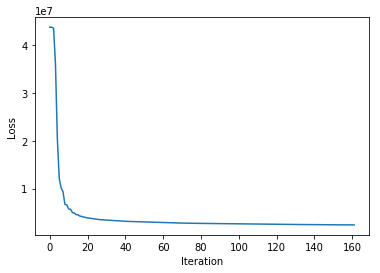

In [11]:
plt.plot(loss_array)
plt.ylabel("Loss")
plt.xlabel("Iteration")
plt.savefig("loss.pdf")
plt.show()

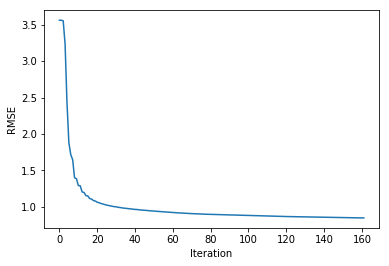

In [12]:
plt.plot(rmse_array)
plt.ylabel("RMSE")
plt.xlabel("Iteration")
plt.savefig("rmse.pdf")
plt.show()

In [13]:
df = pd.DataFrame(index=[10,50,100], columns=[0, 0.001, 0.1])
for k in [10,50,100]:
    for lbd in [0, 0.001, 0.1]:
        _, rmse_arr = decomposition(train_M, test_X, test_y, k=k, lbd=lbd, print_every=10000)
        df.loc[k, lbd] = rmse_arr[-1]
df

KeyboardInterrupt: 

In [14]:
df

,0.0,0.001,0.01,0.1
10,0.862085,0.862085,0.862091,0.862151
20,0.814773,0.812151,0.812157,0.812214
50,0.845369,0.84537,0.845378,0.845457
100,0.821299,NaN,NaN,NaN
